In [57]:
library(parallel)
# 查看可用的CPU核心数
detectCores(logical = FALSE)


[1] 32

In [58]:
# 使用system2命令获取内存信息
system2("grep", "MemTotal /proc/meminfo", stdout = TRUE)

[1] "MemTotal:       2112594368 kB"

In [3]:
library(tidyverse)
library(Pando)
library(dplyr)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(hdf5r)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘BSgenome.Hsapiens.UCSC.hg38’ was built under R version 4.3.3”
Loading required package: GenomeInfoDb

Warning 

In [4]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.4 (Seafoam Ocelot)

Matrix products: default
BLAS/LAPACK: /mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/.conda/envs/R/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/London
tzcode source: system (glibc)

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] hdf5r_1.3.11                      EnsDb.Hsapiens.v86_2.99.0        
 [3] ensembldb_2.26.0                  AnnotationFilter_1.26.0          

In [59]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [60]:
inputdata.10x <- Read10X_h5("./3KPBMC/filtered_feature_bc_matrix.h5")

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [61]:
library(pryr)
mem_used()

6.14 GB

In [62]:
## Genome matrix has multiple modalities, returning a list of matrices for this genome
# extract RNA and ATAC data
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [63]:
# filter peaks by chromosome
atac_counts <- atac_counts[grep("chr", rownames(atac_counts)), ]

An object of class Seurat 
36601 features across 2622 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 2 layers present: counts, data

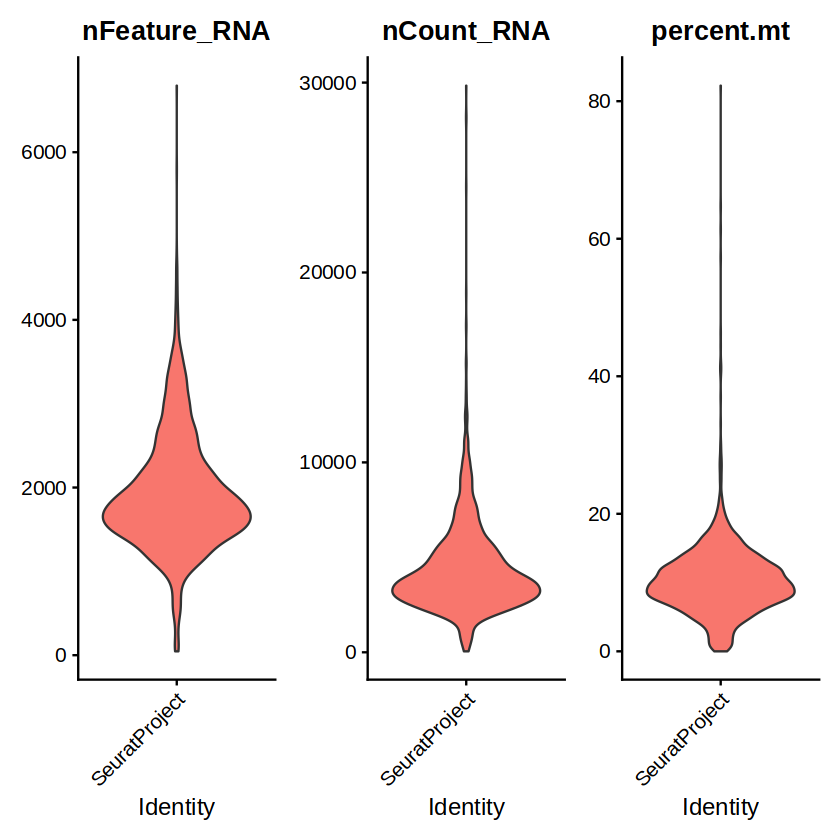

In [64]:
#接下来创建一个 Seurat 对象并过滤 scRNA-seq 数据中的低质量细胞
obj.rna <- CreateSeuratObject(counts = rna_counts)
obj.rna <- NormalizeData(obj.rna, verbose = FALSE)
obj.rna[["percent.mt"]] <- PercentageFeatureSet(obj.rna, pattern = "^MT-")
# Visualize QC metrics as a violin plot
vln1<-VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)
vln1
obj.rna <- subset(obj.rna, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20 & nCount_RNA < 13000)

obj.rna

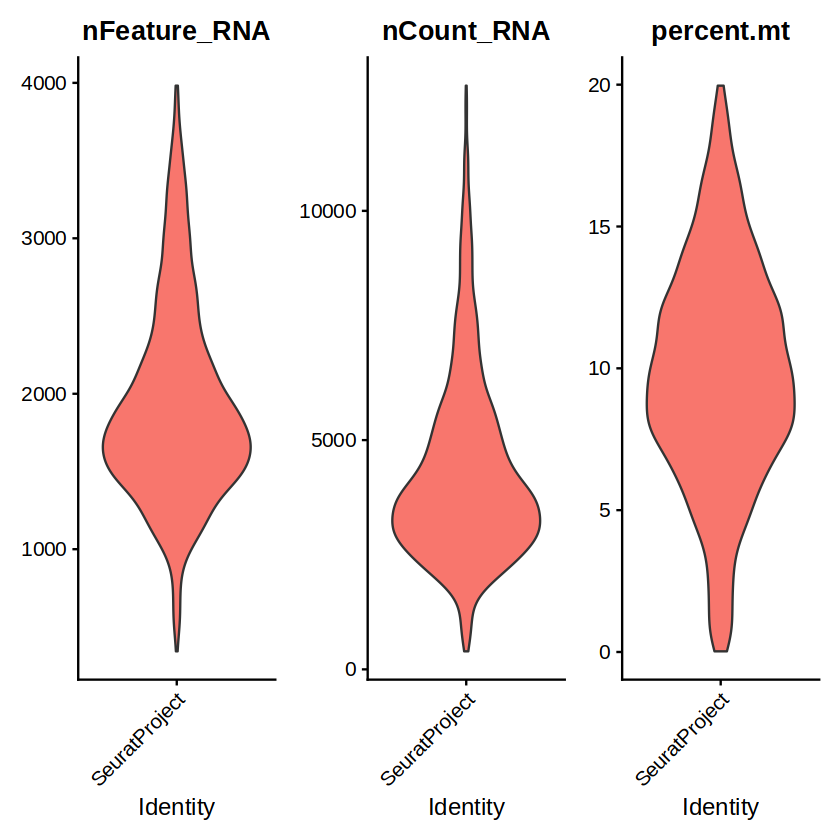

In [65]:
VlnPlot(obj.rna, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

In [66]:
# create seurat object
chrom_assay <- CreateChromatinAssay(
  counts = atac_counts,
  sep = c(":", "-"),
  min.cells = 1,
  genome = 'hg38',
  fragments = './3KPBMC/atac_fragments.tsv.gz'
)

Computing hash



In [67]:
obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "ATAC")

In [68]:
annotations<-readRDS("./models/R-scMEGA/annotations.rds")

In [69]:
annotations

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739     chrM     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789     chrM   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851     chrM     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899     chrM     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

In [70]:
# add the gene information to the object
Annotation(obj.atac) <- annotations

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



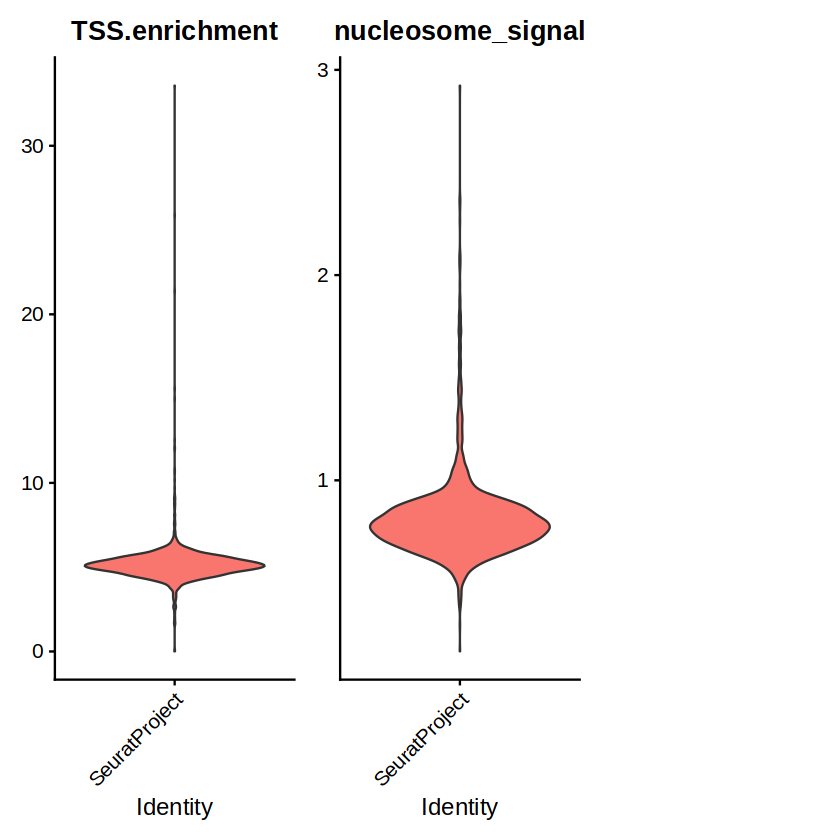

In [71]:
# 计算 TSS 富集分数
obj.atac <- TSSEnrichment(obj.atac, fast = FALSE)

# 计算核小体信号
obj.atac <- NucleosomeSignal(obj.atac)



VlnPlot(
  obj.atac,
  features = c( "TSS.enrichment", "nucleosome_signal"),
  pt.size = 0,
  ncol = 3
)

In [72]:
obj.atac

An object of class Seurat 
151450 features across 2714 samples within 1 assay 
Active assay: ATAC (151450 features, 0 variable features)
 2 layers present: counts, data

In [73]:
# 过滤低质量细胞
obj.atac <- subset(
  x = obj.atac,
  subset =
           nucleosome_signal < 4 & 
           TSS.enrichment > 2
)

In [74]:
obj.atac

An object of class Seurat 
151450 features across 2706 samples within 1 assay 
Active assay: ATAC (151450 features, 0 variable features)
 2 layers present: counts, data

In [75]:
cell.sel <- intersect(colnames(obj.rna), colnames(obj.atac))

In [76]:
obj.rna <- subset(obj.rna, cells = cell.sel)
obj.atac <- subset(obj.atac, cells = cell.sel)

In [77]:
#接下来，我们使用标准 Seurat 和 Signac 分析流程处理 scRNA-seq 和 scATAC-seq 数据：
# normalization followed by dimensionality reduction
obj.rna <- obj.rna %>%
  NormalizeData(verbose=FALSE) %>%
  FindVariableFeatures(nfeatures=3000, verbose=F) %>%
  ScaleData() %>%
  RunPCA(verbose = FALSE) %>%
  RunUMAP(dims = 1:30, verbose = FALSE)

obj.atac <- obj.atac %>%
  RunTFIDF() %>%
  FindTopFeatures() %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30, verbose = FALSE)

Centering and scaling data matrix

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



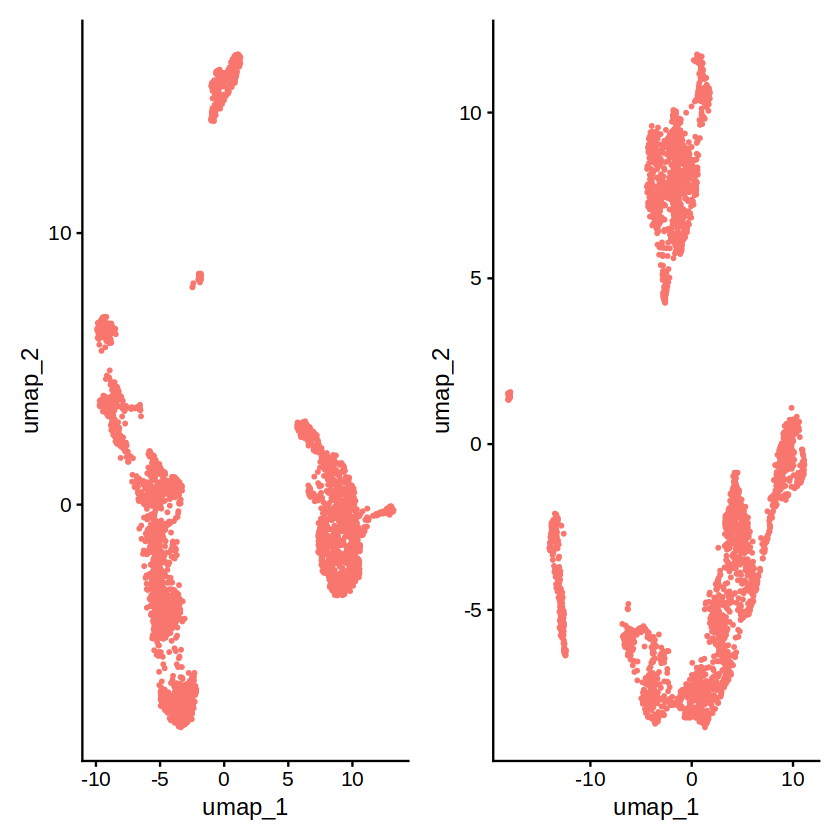

In [78]:
p1 <- DimPlot(obj.rna) + NoLegend()
p2 <- DimPlot(obj.atac) + NoLegend()

p1 + p2

In [79]:
setwd("./models/R-scMEGA")

In [80]:
reference <- readRDS("seurat.rds")
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Warning message:
"Assay RNA changing from Assay to Assay"
Warning message:
"Assay ATAC changing from Assay to Assay"
Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [81]:
#手动更新
reference[["RNA"]] <- CreateAssayObject(counts = reference[["RNA"]]@counts)
reference <- UpdateSeuratObject(object = reference)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in ATAC

Validating object structure for Assay 'RNA'

Validating object structure for Assay 'ATAC'

Object representation is consistent with the most current Seurat version



In [82]:
# we only keep cells with annotated cell type
reference <- subset(reference, subset = celltype != "NA")

Warning message:
"Removing 1877 cells missing data for vars requested"


In [83]:
# run sctransform
reference <- reference %>%
    NormalizeData(verbose=FALSE) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData() %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

Centering and scaling data matrix



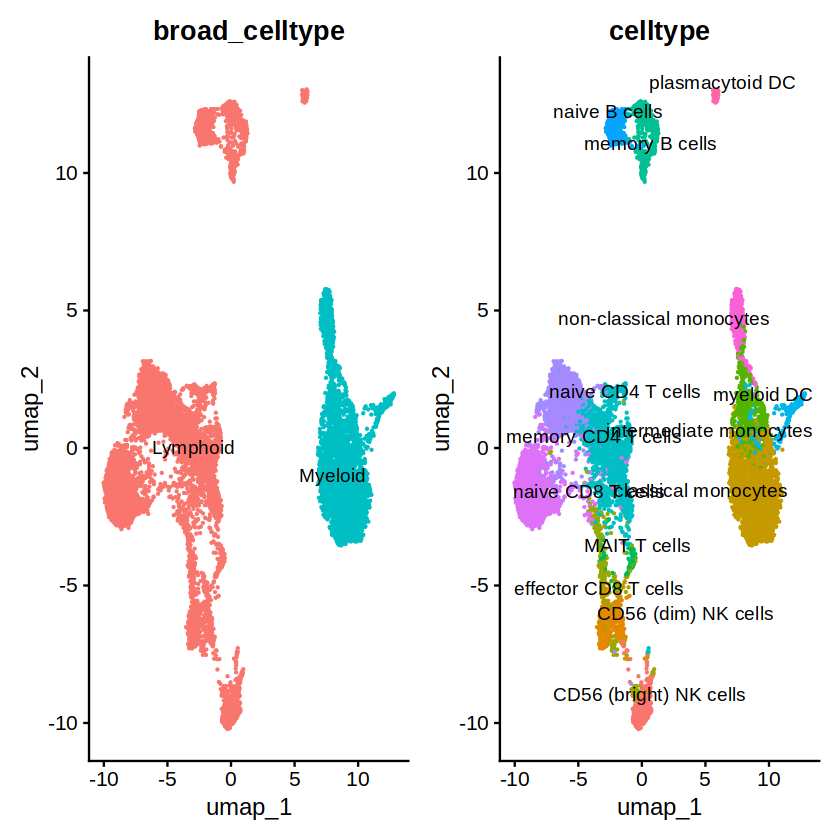

In [84]:
p1 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "broad_celltype") + NoLegend()

p2 <- DimPlot(reference, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "celltype") + NoLegend()

p1 + p2

In [85]:
transfer_anchors <- FindTransferAnchors(
  reference = reference,
  query = obj.rna,
  reference.reduction = "pca",
  dims = 1:30
)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 8922 anchors



In [86]:
predictions <- TransferData(
  anchorset = transfer_anchors, 
  refdata = reference$celltype,
  weight.reduction = obj.rna[['pca']],
  dims = 1:30
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [87]:
obj.rna <- AddMetaData(
  object = obj.rna,
  metadata = predictions
)

obj.atac <- AddMetaData(
  object = obj.atac,
  metadata = predictions
)

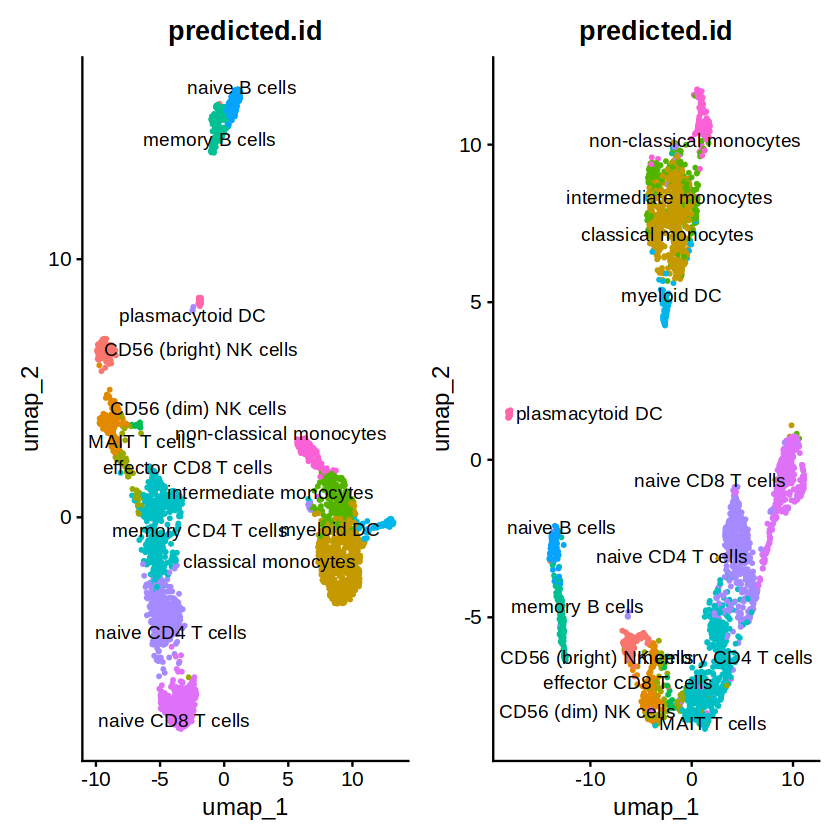

In [88]:
p1 <- DimPlot(obj.rna, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p2 <- DimPlot(obj.atac, label = TRUE, repel = TRUE, 
        reduction = "umap", group.by = "predicted.id") + NoLegend()

p1 + p2

In [89]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj')

In [90]:
meta.data <- obj.rna@meta.data %>%
    as.data.frame()


In [91]:
str(obj.rna)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964 11306 13895 16280 19289 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 36601 2617
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:5034927] 1 2 1 1 1 1 1 1 1 3 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964 

In [92]:
colnames(obj.rna@assays$RNA@layers$counts)<-colnames(obj.rna)

In [93]:
rownames(obj.rna@assays$RNA@layers$counts)<-rownames(obj.rna)

In [94]:
# create a Seurat object containing the RNA adata
pbmc <- CreateSeuratObject(
  counts = obj.rna@assays$RNA@layers$counts,
  assay = "RNA",
    meta.data = meta.data
)


In [95]:
# create ATAC assay and add it to the object
pbmc[["ATAC"]] <- CreateChromatinAssay(
  counts = obj.atac@assays$ATAC@counts,
  sep = c(":", "-"),
    min.cells = 1,
    genome = 'hg38',
    annotation=annotations,
    fragments = './3KPBMC/atac_fragments.tsv.gz'
)

Computing hash



In [96]:
## RNA pre-processing and PCA dimension reduction
DefaultAssay(pbmc) <- "RNA"

pbmc <- pbmc %>%
    NormalizeData(verbose=F) %>%
    FindVariableFeatures(nfeatures=3000, verbose=F) %>%
    ScaleData(verbose=F) %>%
    RunPCA(npcs=50, reduction.name="RNA_PCA", verbose=F)

In [97]:
## ATAC pre-processing and LSI dimension reduction
DefaultAssay(pbmc) <- "ATAC"

pbmc <- pbmc %>%
    RunTFIDF(verbose=F) %>%
    FindTopFeatures(min.cutoff = 'q0', verbose=F) %>%
    RunSVD(verbose=F)

In [98]:
str(pbmc)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ RNA :Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964 11306 13895 16280 19289 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 36601 2617
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:5034927] 1 2 1 1 1 1 1 1 1 3 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964

In [99]:
pbmc

An object of class Seurat 
187810 features across 2617 samples within 2 assays 
Active assay: ATAC (151209 features, 151209 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi

In [143]:
head(pbmc@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,predicted.id,prediction.score.naive.CD4.T.cells,prediction.score.memory.CD4.T.cells,prediction.score.non.classical.monocytes,prediction.score.naive.CD8.T.cells,prediction.score.CD56..bright..NK.cells,⋯,prediction.score.myeloid.DC,prediction.score.intermediate.monocytes,prediction.score.memory.B.cells,prediction.score.MAIT.T.cells,prediction.score.CD56..dim..NK.cells,prediction.score.naive.B.cells,prediction.score.plasmacytoid.DC,prediction.score.max,nCount_ATAC,nFeature_ATAC
,<fct>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
AAACAGCCAAATATCC-1,SeuratProject,4747,2272,7.773331,CD56 (bright) NK cells,0.0000000,0,0,0.00000000,1.0000000,⋯,0.0000000,0.0000000,0,0,0.0000000,0,0,1.0000000,13978,5239
AAACAGCCAGGAACTG-1,SeuratProject,7761,3254,8.929262,intermediate monocytes,0.0000000,0,0,0.00000000,0.0000000,⋯,0.2329523,0.7670477,0,0,0.0000000,0,0,0.7670477,27574,9586
AAACAGCCAGGCTTCG-1,SeuratProject,3666,1798,11.156574,classical monocytes,0.0000000,0,0,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0,0,0.0000000,0,0,1.0000000,27990,9952
AAACCAACACCTGCTC-1,SeuratProject,2162,1145,12.534690,naive B cells,0.0000000,0,0,0.00000000,0.0000000,⋯,0.0000000,0.0000000,0,0,0.0000000,1,0,1.0000000,18031,6362
AAACCAACAGATTCAT-1,SeuratProject,2910,1495,10.068729,CD56 (dim) NK cells,0.0000000,0,0,0.00000000,0.1607015,⋯,0.0000000,0.0000000,0,0,0.8392985,0,0,0.8392985,20311,6939
AAACCAACAGTTGCGT-1,SeuratProject,2616,1342,8.142202,naive CD4 T cells,0.9867589,0,0,0.01324112,0.0000000,⋯,0.0000000,0.0000000,0,0,0.0000000,0,0,0.9867589,20867,7358


In [156]:
labels <- data.frame(barcode_use = rownames(pbmc@meta.data), label= pbmc@meta.data$predicted.id)

In [157]:
labels 

barcode_use,label
<chr>,<chr>
AAACAGCCAAATATCC-1,CD56 (bright) NK cells
AAACAGCCAGGAACTG-1,intermediate monocytes
AAACAGCCAGGCTTCG-1,classical monocytes
AAACCAACACCTGCTC-1,naive B cells
AAACCAACAGATTCAT-1,CD56 (dim) NK cells
AAACCAACAGTTGCGT-1,naive CD4 T cells
AAACCAACATAACGGG-1,memory CD4 T cells
AAACCAACATAGACCC-1,classical monocytes
AAACCGCGTGAGGTAG-1,memory B cells


In [158]:
write.table(labels, file = "3k_labels.txt", sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE)

In [108]:
muo_data<-pbmc

In [101]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj"

In [102]:
library(TFBSTools)
library(JASPAR2020)

In [103]:
muo_data
muo_data[['RNA']]
muo_data[['ATAC']]
data('phastConsElements20Mammals.UCSC.hg38')
data('SCREEN.ccRE.UCSC.hg38')

An object of class Seurat 
187810 features across 2617 samples within 2 assays 
Active assay: ATAC (151209 features, 151209 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi

Assay (v5) data with 36601 features for 2617 cells
Top 10 variable features:
 IGLC2, IGKC, GNLY, TCF4, CDKN1C, PTGDS, IGHM, IGLC1, IGLC3, LINC01478 
Layers:
 counts, data, scale.data 

ChromatinAssay data with 151209 features for 2617 cells
Variable features: 151209 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [104]:
str(muo_data)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ RNA :Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 3
  .. .. .. .. ..$ counts    :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964 11306 13895 16280 19289 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 36601 2617
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:5034927] 1 2 1 1 1 1 1 1 1 3 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. .. ..$ data      :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:5034927] 16 30 43 44 73 83 86 97 104 170 ...
  .. .. .. .. .. .. ..@ p       : int [1:2618] 0 2272 5526 7324 8469 9964

In [105]:
library(peakRAM)

In [106]:
subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)

GRanges object with 502299 ranges and 3 metadata columns:
           seqnames              ranges strand |       idx        name
              <Rle>           <IRanges>  <Rle> | <numeric> <character>
       [1]     chr1   39845835-39845996      * |        13      lod=47
       [2]     chr1   84934642-84934658      * |        19      lod=15
       [3]     chr1 112197515-112197728      * |        22     lod=118
       [4]     chr1 177209331-177209405      * |        30      lod=26
       [5]     chr1 212860862-212860929      * |        34      lod=15
       ...      ...                 ...    ... .       ...         ...
  [502295]    chr22   50729748-50729779      * |       972      lod=17
  [502296]    chr22   50731592-50731785      * |       972     lod=203
  [502297]    chr22   50731824-50732000      * |       972     lod=139
  [502298]    chr22   50732168-50732256      * |       972      lod=48
  [502299]    chr22   50732344-50732453      * |       972      lod=30
               scor

In [107]:
result <- peakRAM({
  # 多行代码示例
muo_data <- initiate_grn(
  muo_data,
  rna_assay = 'RNA',
  peak_assay = 'ATAC',
  regions =  subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)
)
GetGRN(muo_data)
regions <- NetworkRegions(muo_data)
    
#Scanning for motifs
data('motifs')
data('motif2tf')    
    
pfm1 <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)
    
pattern_tfs1 <- sapply(pfm1, name)
    

motif2tf_use <- motif2tf %>%
    dplyr::filter(tf %in% pattern_tfs1)
motifs_use <- motifs[unique(motif2tf_use$motif)]
library(BSgenome.Hsapiens.UCSC.hg38)
muo_data <- find_motifs(
  muo_data, 
  pfm = motifs_use, 
  motif_tfs = motif2tf_use,
  genome = BSgenome.Hsapiens.UCSC.hg38
)
regions <- NetworkRegions(muo_data)
regions@motifs@data[1:5,1:5]
library(doParallel)
registerDoParallel(4)
muo_data <- infer_grn(
  muo_data,
  peak_to_gene_method = 'GREAT',
  genes = pattern_tfs1,
  parallel = T
)    
GetNetwork(muo_data)
coef(muo_data)    
muo_data <- find_modules(
  muo_data, 
  p_thresh = 0.05,
  nvar_thresh = 2, 
  min_genes_per_module = 1, 
  rsq_thresh = 0.1
)   
modules <- NetworkModules(muo_data) 
modules@meta    
})

print(result)

Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"
Warning message:
"package 'doParallel' was built under R version 4.3.3"
Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.3.3"

Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package: iterators

Warning message:
"package 'iterators' was built under R version 4.3.3"
Warning message:
"package 'Matrix' was built under R version 4.3.2"

Attaching package: 'Matrix'


The following object is masked from 'package:TFBSTools':

    Matrix


The following object is masked from 'package:S4Vectors':

    expand


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8

Selecting candidate regulatory regi

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Function_Call
1 {muo_data<-initiate

[1] 1

In [ ]:
#启动 GRN

In [109]:
muo_data <- initiate_grn(
  muo_data,
  rna_assay = 'RNA',
  peak_assay = 'ATAC',
  regions = subsetByOverlaps(phastConsElements20Mammals.UCSC.hg38, SCREEN.ccRE.UCSC.hg38)
)

muo_data

An object of class "GRNData"
Slot "grn":
A RegulatoryNetwork object 
Candidate regions have not been scanned for motifs

No network has been inferred

Slot "data":
An object of class Seurat 
187810 features across 2617 samples within 2 assays 
Active assay: ATAC (151209 features, 151209 variable features)
 2 layers present: counts, data
 1 other assay present: RNA
 2 dimensional reductions calculated: RNA_PCA, lsi


In [110]:
GetGRN(muo_data)

A RegulatoryNetwork object 
Candidate regions have not been scanned for motifs

No network has been inferred

In [111]:
regions <- NetworkRegions(muo_data)
regions@ranges

GRanges object with 137375 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   39845835-39845996      *
       [2]     chr1 212860862-212860929      *
       [3]     chr1 235929599-235929645      *
       [4]     chr1   44826482-44826487      *
       [5]     chr1   44826769-44826771      *
       ...      ...                 ...    ...
  [137371]    chr22   50679011-50679018      *
  [137372]    chr22   50691660-50691859      *
  [137373]    chr22   50705299-50705519      *
  [137374]    chr22   50724041-50724084      *
  [137375]    chr22   50729610-50729721      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [112]:
#Scanning for motifs
data('motifs')
data('motif2tf')

In [113]:
motifs

PFMatrixList of length 1590
names(1590): M07783_2.00 M07784_2.00 M02651_2.00 ... UN0339.1 UN0340.1 UN0341.1

In [114]:
motif2tf

motif,tf,origin,gene_id,family,name,symbol,motif_tf
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
M07783_2.00,TFAP2D,CIS-BP,ENSG00000008197,AP-2,NA,NA,NA
M07784_2.00,TFAP2D,CIS-BP,ENSG00000008197,AP-2,NA,NA,NA
M02651_2.00,ARID3A,CIS-BP,ENSG00000116017,ARID/BRIGHT,NA,NA,NA
M08707_2.00,ARID5B,CIS-BP,ENSG00000150347,ARID/BRIGHT,NA,NA,NA
M00116_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01657_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01661_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01663_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA
M01668_2.00,ARID5A,CIS-BP,ENSG00000196843,ARID/BRIGHT,NA,NA,NA


pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

pfm1 <- getMatrixSet(
  x = JASPAR2020,
  opts = list(species = "Homo sapiens", all_versions = FALSE)
)

In [115]:
pfm1 <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)


# 获取转录因子名称
pattern_tfs <- sapply(pfm, name)

In [116]:
pattern_tfs1 <- sapply(pfm1, name)

In [117]:
pattern_tfs1

MA0004.1              MA0006.1              MA0019.1 
               "Arnt"           "Ahr::Arnt"        "Ddit3::Cebpa" 
             MA0029.1              MA0030.1              MA0031.1 
              "Mecom"               "FOXF2"               "FOXD1" 
             MA0040.1              MA0041.1              MA0051.1 
              "Foxq1"               "Foxd3"                "IRF2" 
             MA0057.1              MA0059.1              MA0066.1 
        "MZF1(var.2)"            "MAX::MYC"               "PPARG" 
             MA0067.1              MA0069.1              MA0070.1 
               "Pax2"                "PAX6"                "PBX1" 
             MA0071.1              MA0072.1              MA0073.1 
               "RORA"         "RORA(var.2)"               "RREB1" 
             MA0074.1              MA0077.1              MA0078.1 
          "RXRA::VDR"                "SOX9"               "Sox17" 
             MA0084.1              MA0087.1              MA0091.1 
                "SRY"                "Sox5"          "TAL1::TCF3" 
             MA0092.1              MA0101.1              MA0107.1 
        "Hand1::Tcf3"                 "REL"                "RELA" 
             MA0108.2              MA0109.1              MA0111.1 
                "TBP"                "HLTF"                "Spz1" 
             MA0115.1              MA0116.1              MA0119.1 
        "NR1H2::RXRA"              "Znf423"          "NFIC::TLX1" 
             MA0125.1              MA0130.1              MA0135.1 
              "Nobox"             "ZNF354C"                "Lhx3" 
             MA0139.1              MA0142.1              MA0149.1 
               "CTCF"        "Pou5f1::Sox2"          "EWSR1-FLI1" 
             MA0138.2              MA0002.2              MA0065.2 
               "REST"               "RUNX1"         "Pparg::Rxra" 
             MA0151.1              MA0152.1              MA0155.1 
             "Arid3a"              "NFATC2"               "INSM1" 
             MA0159.1              MA0160.1              MA0163.1 
         "RARA::RXRA"               "NR4A2"               "PLAG1" 
             MA0164.1              MA0259.1              MA0146.2 
              "Nr2e3"         "ARNT::HIF1A"                 "Zfx" 
             MA0467.1              MA0468.1              MA0476.1 
                "Crx"                "DUX4"                 "FOS" 
             MA0478.1              MA0479.1              MA0480.1 
              "FOSL2"               "FOXH1"               "Foxo1" 
             MA0483.1              MA0488.1              MA0489.1 
              "Gfi1b"                 "JUN"          "JUN(var.2)" 
             MA0492.1              MA0493.1              MA0494.1 
        "JUND(var.2)"                "Klf1"         "Nr1h3::Rxra" 
             MA0497.1              MA0501.1              MA0503.1 
              "MEF2C"           "MAF::NFE2"       "Nkx2-5(var.2)" 
             MA0504.1              MA0505.1              MA0506.1 
              "NR2C2"               "Nr5a2"                "NRF1" 
             MA0507.1              MA0513.1              MA0514.1 
             "POU2F2" "SMAD2::SMAD3::SMAD4"                "Sox3" 
             MA0515.1              MA0517.1              MA0518.1 
               "Sox6"        "STAT1::STAT2"               "Stat4" 
             MA0519.1              MA0520.1              MA0521.1 
     "Stat5a::Stat5b"               "Stat6"               "Tcf12" 
             MA0523.1              MA0527.1              MA0076.2 
             "TCF7L2"              "ZBTB33"                "ELK4" 
             MA0258.2              MA0050.2              MA0150.2 
               "ESR2"                "IRF1"              "Nfe2l2" 
             MA0137.3              MA0144.2              MA0140.2 
              "STAT1"               "STAT3"         "GATA1::TAL1" 
             MA0095.2              MA0591.1              MA0593.1 
                "YY1"         "Bach1::Mafk"               "F

In [118]:

motif2tf_use <- motif2tf %>%
    dplyr::filter(tf %in% pattern_tfs1)
motifs_use <- motifs[unique(motif2tf_use$motif)]
motif2tf_use

motif,tf,origin,gene_id,family,name,symbol,motif_tf
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
M03447_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M05709_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M05710_2.00,NFAT5,CIS-BP,ENSG00000102908,Rel,NA,NA,NA
M09371_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
M09631_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
M09632_2.00,RUNX1,CIS-BP,ENSG00000159216,Runt,NA,NA,NA
MA0030.1,FOXF2,JASPAR2020,NA,Forkhead box (FOX) factors,FOXF2,FOXF2,NA
MA0031.1,FOXD1,JASPAR2020,NA,Forkhead box (FOX) factors,FOXD1,FOXD1,NA
MA0051.1,IRF2,JASPAR2020,NA,Interferon-regulatory factors,IRF2,IRF2,NA


In [119]:
motifs_use

PFMatrixList of length 633
names(633): M03447_2.00 M05709_2.00 M05710_2.00 ... UN0118.1 UN0307.1 UN0308.1

In [120]:
library(BSgenome.Hsapiens.UCSC.hg38)
muo_data <- find_motifs(
  muo_data, 
  pfm = motifs_use, 
  motif_tfs = motif2tf_use,
  genome = BSgenome.Hsapiens.UCSC.hg38
)


Adding TF info

Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
"Non-unique motif names supplied, making unique"


In [121]:
regions <- NetworkRegions(muo_data)
regions@motifs@data[1:5,1:5]


5 x 5 sparse Matrix of class "lgCMatrix"
                         M03447_2.00 M05709_2.00 M05710_2.00 M09371_2.00
chr1-39845835-39845996             .           .           .           |
chr1-212860862-212860929           .           .           .           .
chr1-235929599-235929645           .           .           .           .
chr1-44826482-44826487             .           .           .           .
chr1-44826769-44826771             .           .           .           .
                         M09631_2.00
chr1-39845835-39845996             .
chr1-212860862-212860929           .
chr1-235929599-235929645           .
chr1-44826482-44826487             .
chr1-44826769-44826771             .

In [122]:
getwd()

[1] "/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj"

In [123]:
setwd('/mnt/iusers01/fatpou01/bmh01/msc-healthdatasci-2023-2024/z89953zj/models/R-pando')

In [124]:
#推断grn

In [125]:
library(doParallel)
registerDoParallel(4)

In [126]:
muo_data <- infer_grn(
  muo_data,
  peak_to_gene_method = 'GREAT',
  genes = pattern_tfs1,
  parallel = T
)

Selecting candidate regulatory regions near genes

Preparing model input

Fitting models for 558 target genes



In [127]:
GetNetwork(muo_data)
coef(muo_data)

A Network object
with 225 TFs and 235 target genes

tf,target,region,term,estimate,std_err,statistic,pval,padj,corr
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RFX5,GATA1,chrX-48835725-48835802,chrX_48835725_48835802:RFX5,5.002337e-05,0.006174575,0.008101508,9.935366e-01,9.987870e-01,0.1006594
RFX5,GATA1,chrX-48917471-48917541,RFX5:chrX_48917471_48917541,-3.420169e-04,0.004388284,-0.077938636,9.378828e-01,9.959197e-01,0.1006594
THAP1,GATA1,chrX-48940604-48940667,chrX_48940604_48940667:THAP1,2.836185e-02,0.003890969,7.289148436,4.112975e-13,3.155380e-11,0.1049611
POU6F1,GATA1,chrX-49002557-49002586,chrX_49002557_49002586:POU6F1,-1.502288e-04,0.004344643,-0.034577932,9.724189e-01,9.983695e-01,0.1003138
KLF4,TFE3,chrX-48470257-48470275,chrX_48470257_48470275:KLF4,2.431123e-03,0.017608662,0.138064049,8.902006e-01,9.838065e-01,0.1289383
CEBPD,TFE3,chrX-48531550-48531949,chrX_48531550_48531949:CEBPD,1.603230e-02,0.017977429,0.891801624,3.725825e-01,7.930423e-01,0.1051373
KLF4,TFE3,chrX-48531550-48531949,KLF4:chrX_48531550_48531949,-1.929327e-02,0.014885392,-1.296121287,1.950497e-01,6.315483e-01,0.1289383
KLF4,TFE3,chrX-48535810-48535916,KLF4:chrX_48535810_48535916,-1.300874e-02,0.013045569,-0.997176560,3.187724e-01,7.529754e-01,0.1289383
MEF2A,TFE3,chrX-48550417-48550489,chrX_48550417_48550489:MEF2A,7.947378e-03,0.007874723,1.009226304,3.129608e-01,7.490047e-01,0.1056933


In [128]:
#Module discovery

In [129]:
muo_data <- find_modules(
  muo_data, 
  p_thresh = 0.05,
  nvar_thresh = 2, 
  min_genes_per_module = 1, 
  rsq_thresh = 0.1
)

Found 123 TF modules



In [130]:
modules <- NetworkModules(muo_data) 
modules@meta

tf,target,estimate,n_regions,n_genes,n_tfs,regions,pval,padj
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
ATF3,BCL6,0.13244488,9,7,8,chr3-188153730-188153871,1.421682e-03,3.105619e-02
ATF3,FOSL1,0.07582960,4,7,4,chr11-64924111-64924185,9.250380e-04,2.203872e-02
ATF3,FOXO3,0.23530507,2,7,2,chr6-108558366-108558649,6.976366e-04,1.769922e-02
ATF3,JDP2,0.06818777,9,7,8,chr14-75426803-75426913,9.434572e-04,2.221350e-02
ATF3,MITF,0.06302763,4,7,4,chr3-69558878-69559023,1.148487e-05,4.626844e-04
ATF3,NR4A1,0.16256284,7,7,7,chr12-52064220-52064406,4.651285e-05,1.617759e-03
ATF3,TFEC,0.13949263,12,7,10,chr7-116211546-116211567,1.876751e-03,3.869809e-02
ATF7,KLF4,-0.27385497,17,1,19,chr9-108272091-108272367,2.590090e-08,1.437007e-06
BACH1,ATF3,0.11550425,10,7,10,chr1-212605646-212605802,2.315720e-05,8.695609e-04


In [131]:
max(modules@meta['n_tfs'])

[1] 19

In [132]:
GetNetwork(muo_data)


A Network object
with 123 TFs and 88 target genes

Warning message:
"Using alpha for a discrete variable is not advised."


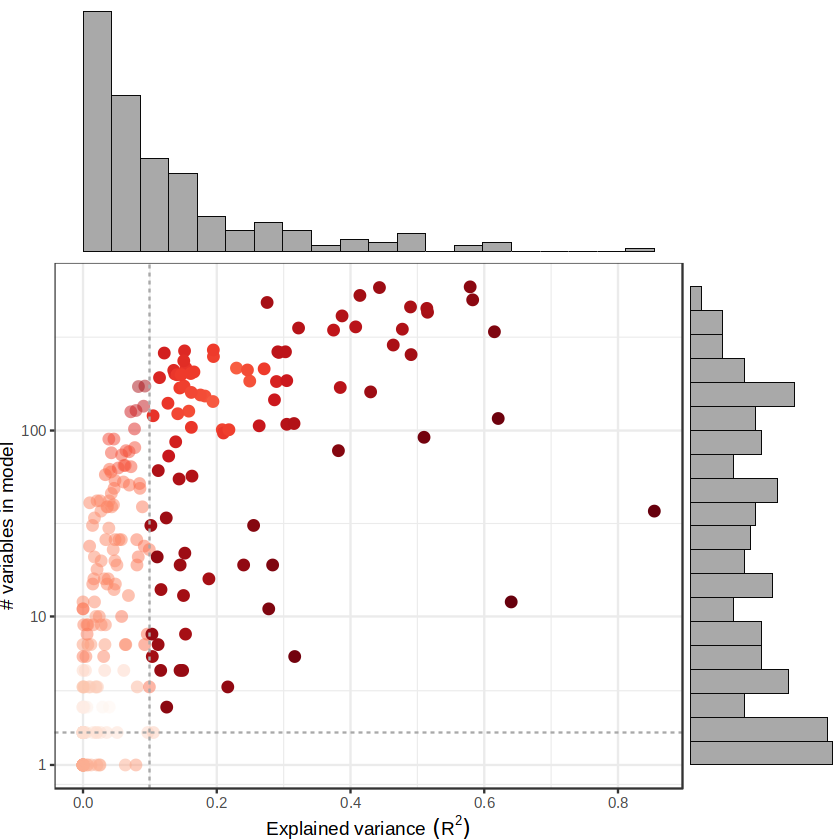

In [133]:
a<-plot_gof(muo_data, point_size=3)
a
#ggsave(filename='plot1.png',plot=a,width=8,height=8,dpi=300)

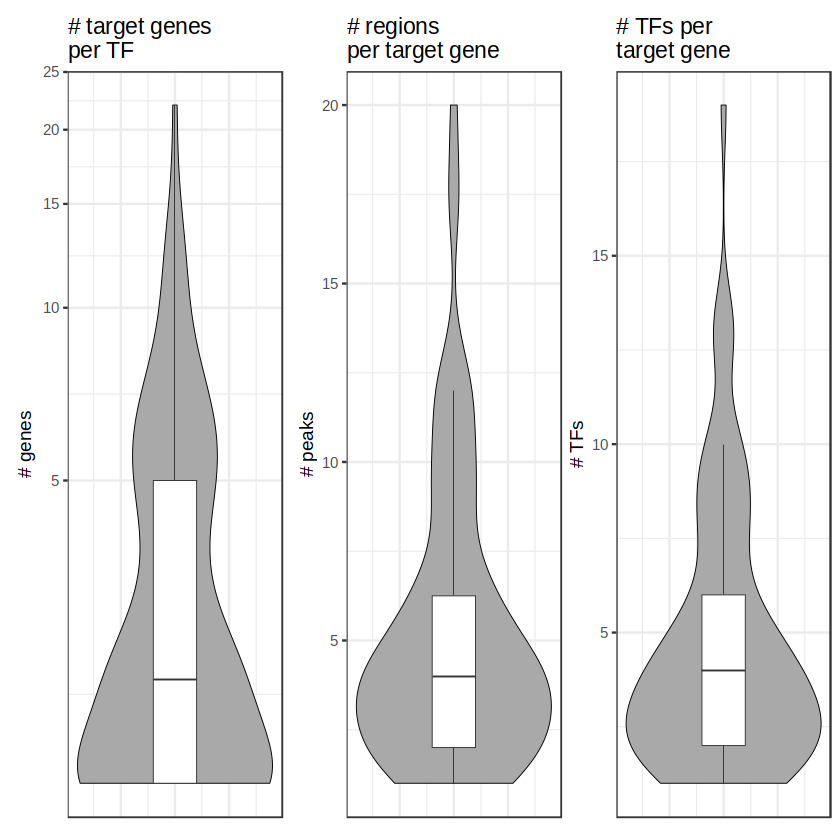

In [134]:
b<-plot_module_metrics(muo_data)
b
#ggsave(filename='plot2.png',plot=b,width=8,height=8,dpi=300)

In [156]:
#Visualizing the GRN

Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Getting network graph



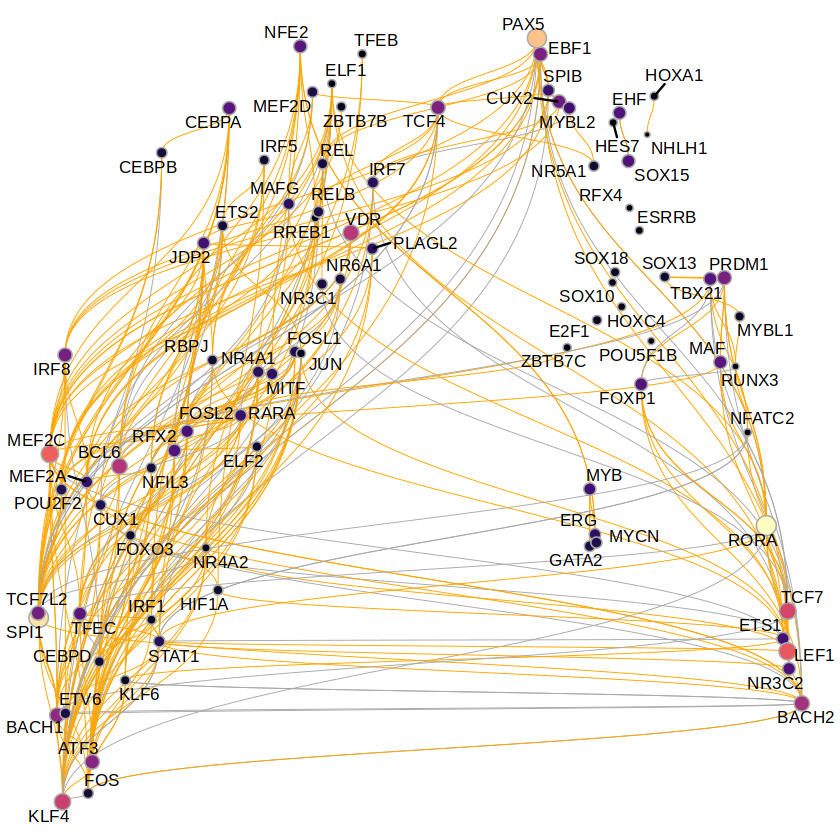

In [135]:
muo_data <- get_network_graph(muo_data)
p3<-plot_network_graph(muo_data)
p3
#ggsave(filename='plot3.png',plot=p3,width=8,height=8,dpi=600)

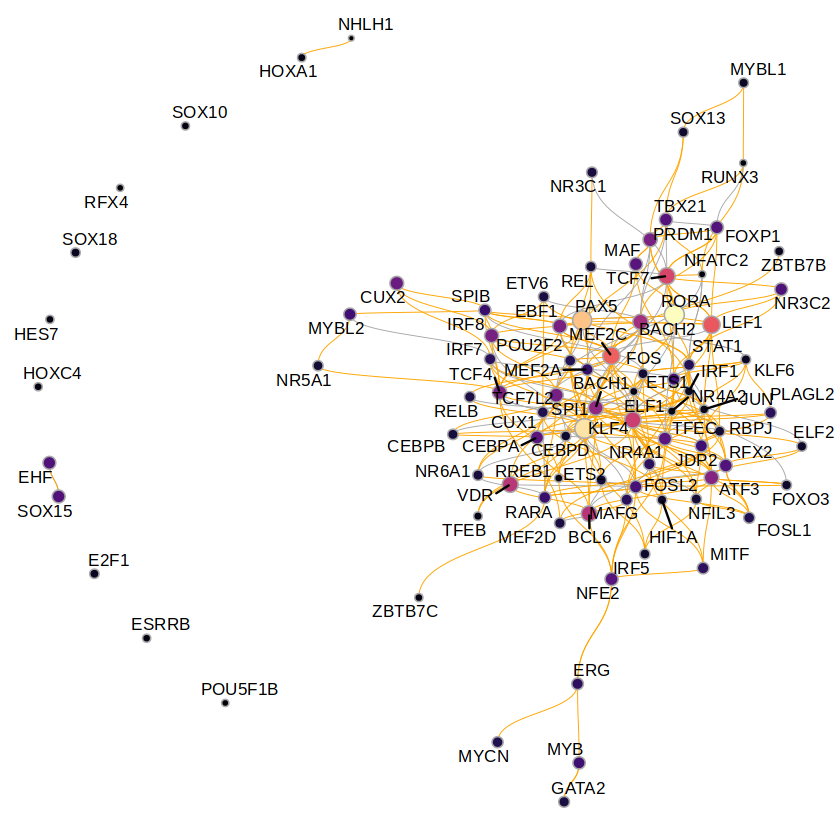

In [136]:
p4<-plot_network_graph(muo_data, layout='fr')
p4
#ggsave(filename='plot4.png',plot=p4,width=8,height=8,dpi=600)

In [137]:
muo_data <- get_network_graph(muo_data, graph_name='umap_graph')

Computing gene-gene correlation

Computing weighted regulatory factor

Computing UMAP embedding

Getting network graph



In [138]:
muo_data <- get_network_graph(
    muo_data, 
    graph_name = 'full_graph', 
    umap_method = 'none'
)

Getting network graph



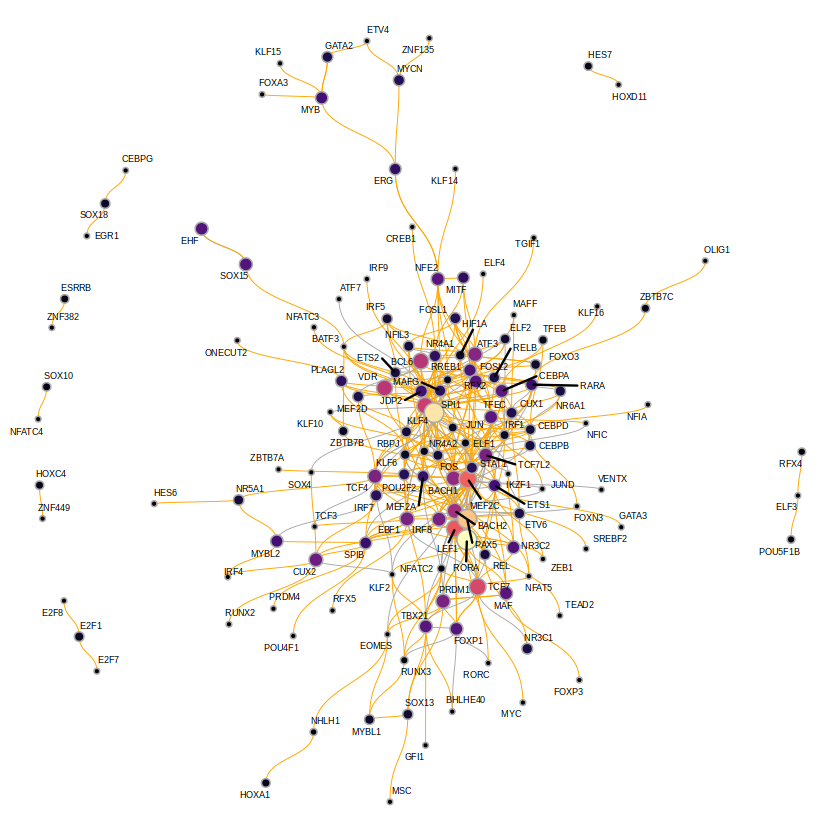

In [139]:
p5 <- plot_network_graph(muo_data, graph='full_graph', layout='fr', text_size=5)
p5
#ggsave(filename='plot5.png',plot=p5,width=8,height=8,dpi=600)

Getting shortest paths from TF

Pruning graph



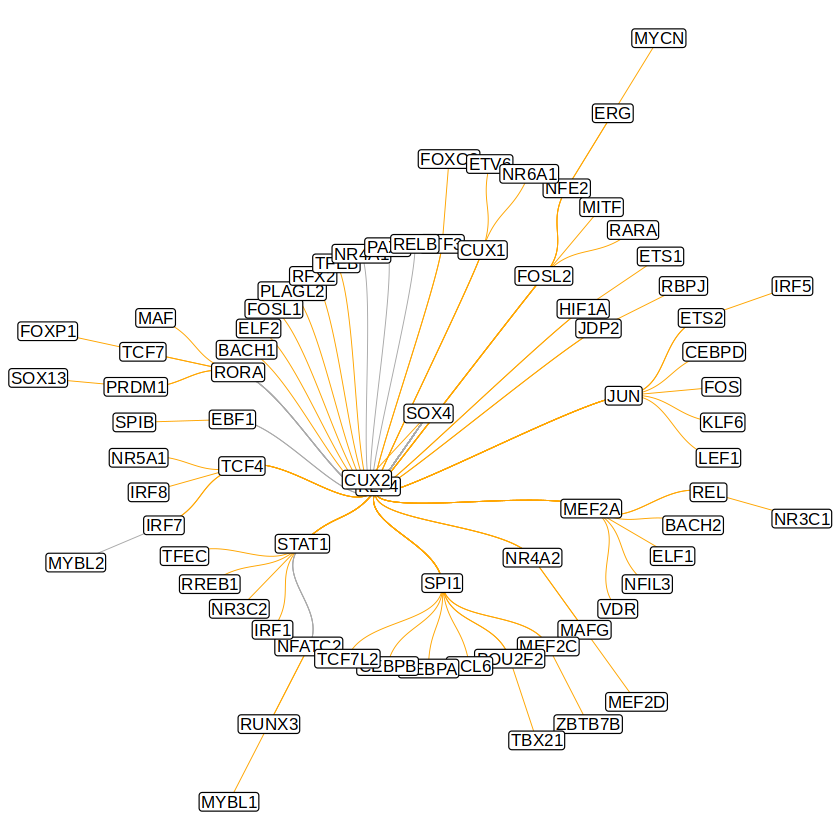

In [140]:
muo_data <- get_tf_network(muo_data, tf='SOX4', graph='full_graph')
p7<-plot_tf_network(muo_data, tf='SOX4')
p7
#ggsave(filename='plot7.png',plot=p7,width=8,height=8,dpi=300)

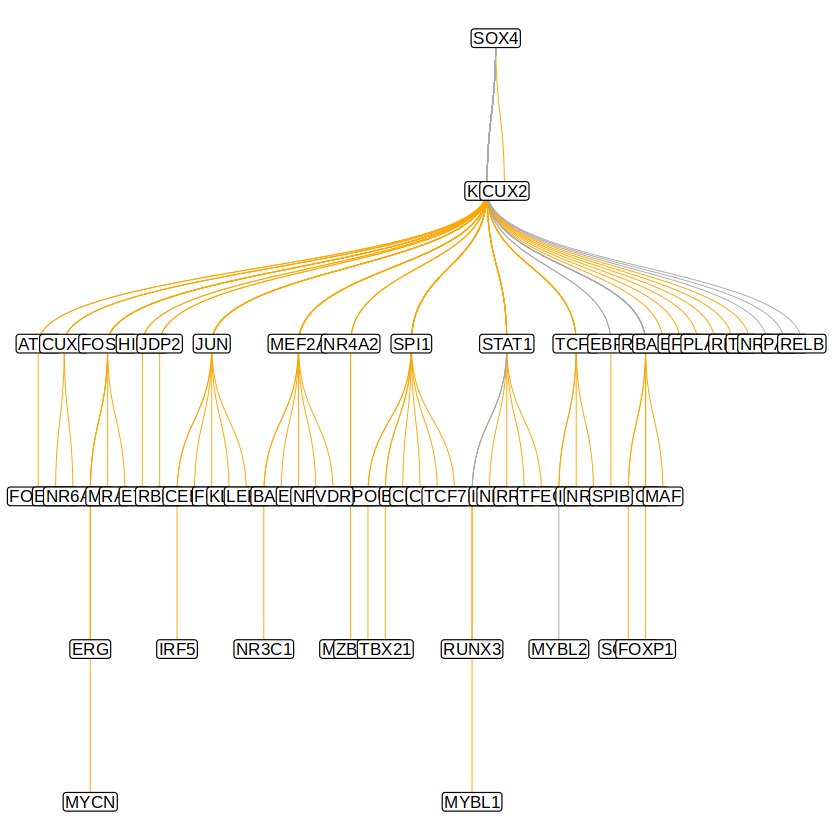

In [141]:
p8<-plot_tf_network(muo_data, tf='SOX4', circular=F)
p8
#ggsave(filename='plot8.png',plot=p8,width=8,height=8,dpi=300)

In [142]:
library(pryr)
mem_used()

6.14 GB